# Exploratory Data Analysis - Proportionality of NL and SC
> Prototyping A: Code Completion

This notebook focuses on extracting the most frequent and less frequent concepts (level_1) for all the datasets

*Notebook Structure*
- Notebook parameters
- Source Code
    - Imports
    - Frequency Dataframes
    - Data Loading
    - Statistics
    - Calculate statistics and frequencies
- Experiment [1.1.1]
- Experiment [1.1.2]

*General Instructions*
* Collapse cells by tittle to improve the navigation
* Before running the experiments, it is required to have global_taxonomy_results for each dataset. global_taxonomy_results contains a the aggregations of rationales by level_1 taxonomomy. 
* Read description on each experiment for further instructions

In [1]:
def param_default():
    return {
        'model': 'codeparrot',
        'modality' : 'nl_sc',
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        'num_experiments' : 30, 
        'bootstrapping_size': 500,
        ######## INPUT 
        'global_taxonomy_results': '/workspaces/code-rationales/data/global_taxonomy_results',
        ######## OUTPUT
        'quantitative_results' : '/workspaces/code-rationales/data/experiments/quantitative_results',
    }
    
params = param_default()

## Source Code

### Imports

In [2]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist
from venn import venn

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


pd.options.display.float_format = '{:.2f}'.format

In [3]:
from code_rationales.taxonomies import *
import os.path

### Frequency Dataframes

In [4]:
def flat_global_results(experiment_global_result: dict):
    flatten_results = { key: [] for key in experiment_global_result.keys() } ## There are 31 fixed categories
    for target_key, rationales in experiment_global_result.items():
        for rational_key, rational_values in rationales.items():
            flatten_results[rational_key] += rational_values
    return flatten_results

In [5]:
def create_frequencies_dataframe(experients_global_results: list):
    frequencies_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        frequencies_df = frequencies_df.append({key: len(value) for key, value in rationales_results.items()}, ignore_index=True)
    frequencies_df = frequencies_df.fillna(0)   
    return frequencies_df


### Data Loading

In [6]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'

In [7]:
def get_experiments_results(dataset_id:str , name:str):
    experiment_paths = [get_experiment_path(params['global_taxonomy_results'] + '/' + params['model'] + '/' + params['modality'], params['datasets'][dataset_id], exp) for exp in range(params['num_experiments'])]
    experiment_global_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_global_results.append(json.loads(file.read()))
    return experiment_global_results

### Statistics 

In [8]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [9]:
def confidence_intervals_large_samples(data, confidence=0.95):
    """
    @confidence: confidence interval 
    @return: tuple (lowerbound, uperbound, h-value)
    """
    dist = NormalDist.from_samples( data )
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [10]:
def boostrap_dictionary(dictionary: dict, size):
    boostrapped_dict = {}
    for key, values in dictionary.items():
        if values:
            boostrapped_dict[key] = bootstrapping(values, np.mean, size)
    return boostrapped_dict

### Calculate statistics and frequencies

In [11]:
### CREATE GROUP FREQUENCY RESULTS
def calculate_results(global_dataframe):
    results_df = pd.DataFrame(columns=['type', 'group', 'category', 'mean', 'median', 'std', 'ci', 'total'])
    for category in global_dataframe.columns:
        experiments_values = global_dataframe[category].tolist()
        try:
            group = [key for key, value in global_groups().items() if category in value][0] ## Mapping from taxonomy groups
        except Exception as e:
            print(e)
        results_df = results_df.append({
            'type': group.split('_')[0], 
            'group': group, 
            'category': category, 
            'median' : np.median(experiments_values),
            'mean' : np.mean(experiments_values), 
            'std' : np.std(experiments_values),
            'ci' : confidence_intervals_large_samples(experiments_values),
            'total' : global_dataframe[category].sum()
        }, ignore_index=True)
    return results_df.sort_values(by='median', ascending=False).reset_index(drop=True)

In [12]:
def get_frequencies_df():
    frequencies_df = pd.DataFrame(columns=['category', 'total', 'dataset_id'])
    for dataset_id in params['datasets'].keys():
        dataset_global_results = get_experiments_results(dataset_id, 'level_1')
        global_frequencies_dataframe_results = calculate_results(create_frequencies_dataframe(dataset_global_results)).sort_values(by=['group','mean'],ascending=[True, False])
        global_frequencies_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['model'] + '/' + params['modality']  + '/' + params['datasets'][dataset_id] + '_frequencies' + '.csv', index=False)
        dataset_frequency_df = global_frequencies_dataframe_results[['category', 'total']].copy()
        dataset_frequency_df['dataset_id'] = [dataset_id]*dataset_frequency_df.shape[0]
        frequencies_df = pd.concat([frequencies_df,dataset_frequency_df], ignore_index=True)
        frequencies_df['total'] = pd.to_numeric(frequencies_df['total'])
        frequencies_df.to_csv(params['quantitative_results'] + '/' + params['model'] + '/' + params['modality']  + '/' + params['datasets'][dataset_id] + '_frequencies_dataset' + '.csv', index=False)
    return frequencies_df

## Experiment [1.1.1]
**Level 1 top 20 most frequent rationales**

*Research Question: What are the most frequent rationales for code completion?*

General Instructions: Execute this experiment per modality separately
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: create a dataframe of frequencies
- gets all level_1 aggregation results of the 30 executions per dataset
- merges the results into a single dataframe and calculate statistics on each level_1 category
- stores the resulting dataframe for future reference (used in experiments 1.2.x)

In [13]:
frequencies_df = get_frequencies_df()

#### Step 2: Most frequent concepts - SG_BD

In [14]:
top_20_most_frequent_df = pd.DataFrame(columns=['category', 'total', 'dataset_id'])

In [15]:
top_20_most_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'SG_BD'].nlargest(20, 'total')
top_20_most_frequent_df = pd.concat([top_20_most_frequent_df, top_20_most_frequent_concepts_df], ignore_index=True)
top_20_most_frequent_concepts_df

,category,total,dataset_id
12,errors,6124183,SG_BD
0,excluded,5039697,SG_BD
16,expression,3909790,SG_BD
22,structural,2330233,SG_BD
13,identifier,2311418,SG_BD
8,nl_noun,2293868,SG_BD
17,indentation,2072568,SG_BD
18,punctuation,1643176,SG_BD
23,statements,880435,SG_BD
32,unknown,517441,SG_BD


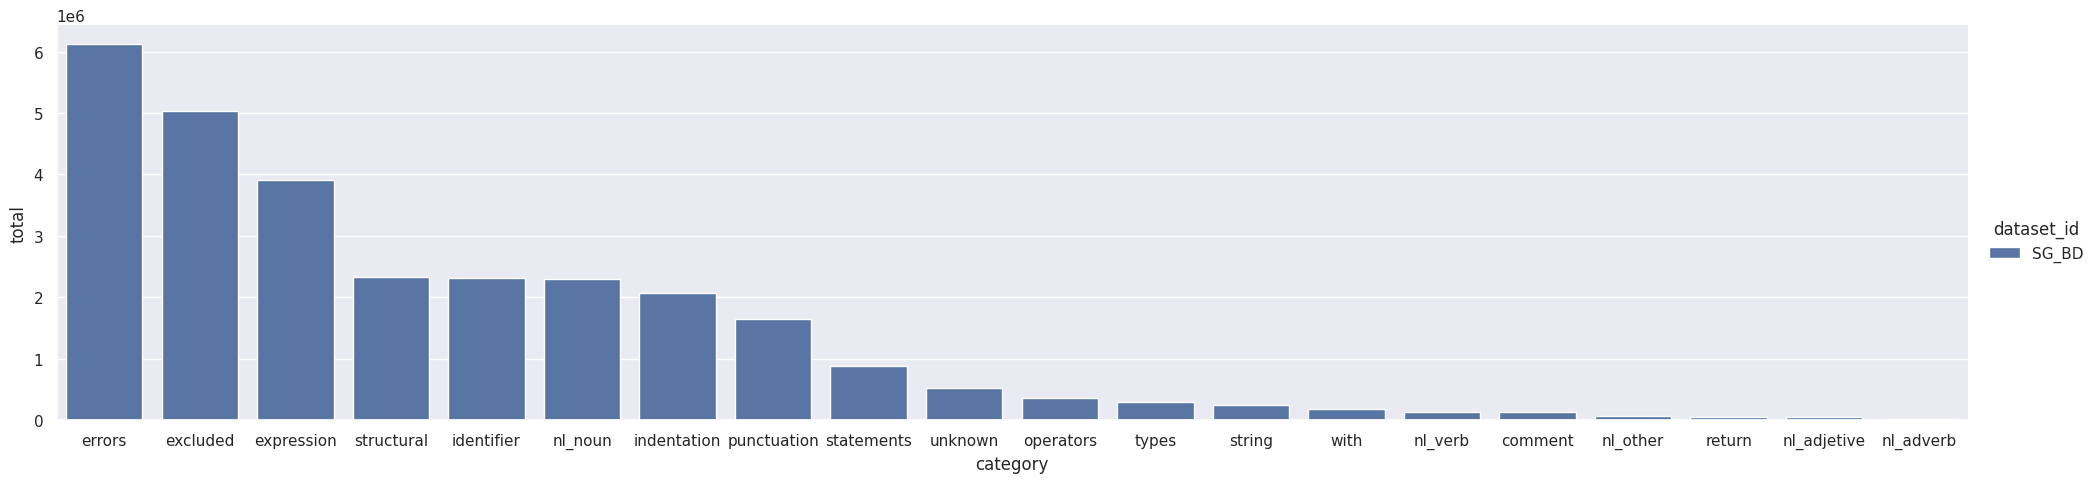

In [16]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_most_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 3: Most frequent concepts - DC_SG_BD

In [17]:
top_20_most_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'DC_SG_BD'].nlargest(20, 'total')
top_20_most_frequent_df = pd.concat([top_20_most_frequent_df, top_20_most_frequent_concepts_df], ignore_index=True)
top_20_most_frequent_concepts_df

,category,total,dataset_id
56,structural,39510443,DC_SG_BD
34,excluded,20568908,DC_SG_BD
57,statements,15617679,DC_SG_BD
42,nl_noun,12107361,DC_SG_BD
50,expression,11282856,DC_SG_BD
51,indentation,11136278,DC_SG_BD
47,identifier,8991504,DC_SG_BD
66,unknown,8608041,DC_SG_BD
46,errors,7071012,DC_SG_BD
52,punctuation,5839301,DC_SG_BD


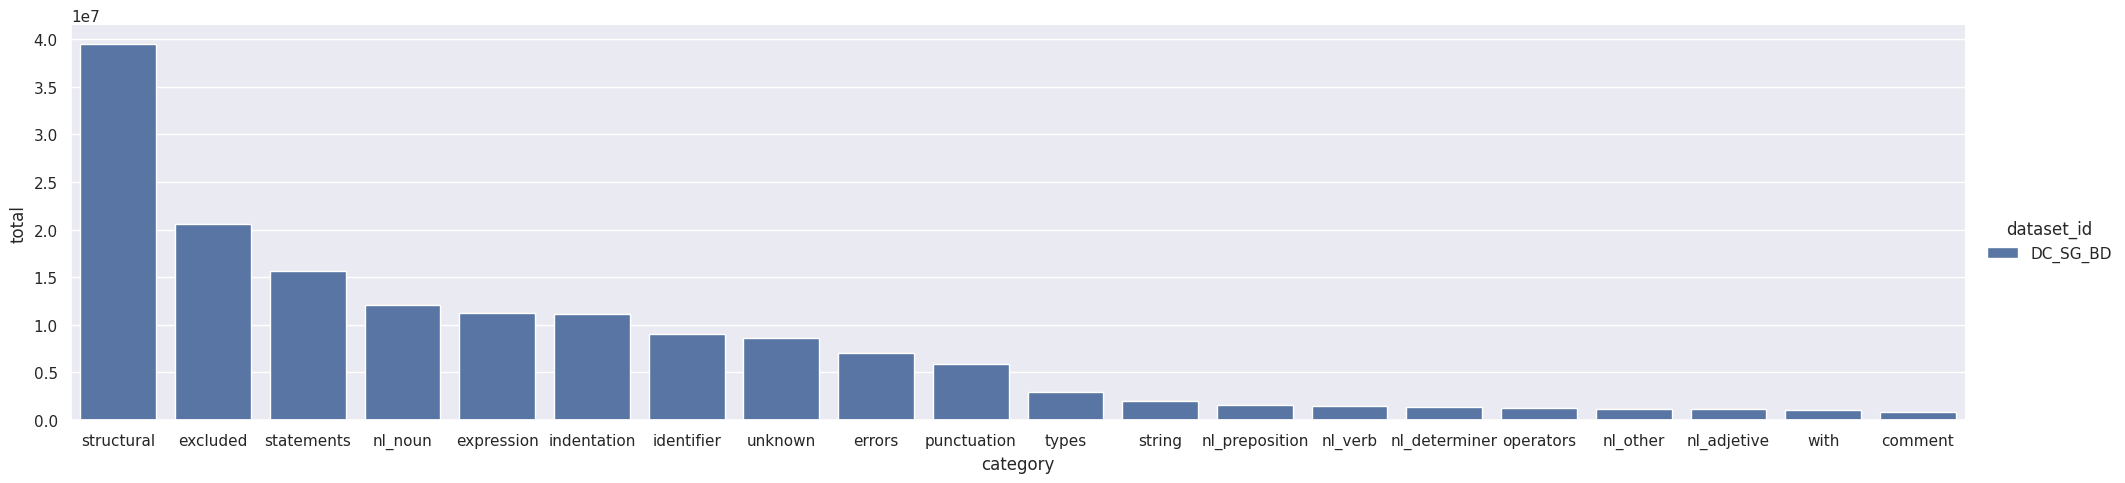

In [18]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_most_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 4: Most frequent concepts - DC_SG

In [19]:
top_20_most_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'DC_SG'].nlargest(20, 'total')
top_20_most_frequent_df = pd.concat([top_20_most_frequent_df, top_20_most_frequent_concepts_df], ignore_index=True)
top_20_most_frequent_concepts_df

,category,total,dataset_id
90,structural,35804097,DC_SG
68,excluded,20953463,DC_SG
84,indentation,13700494,DC_SG
91,statements,12662336,DC_SG
76,nl_noun,11406535,DC_SG
85,expression,9987750,DC_SG
81,identifier,8553646,DC_SG
80,errors,7375820,DC_SG
100,unknown,6328072,DC_SG
86,punctuation,5124519,DC_SG


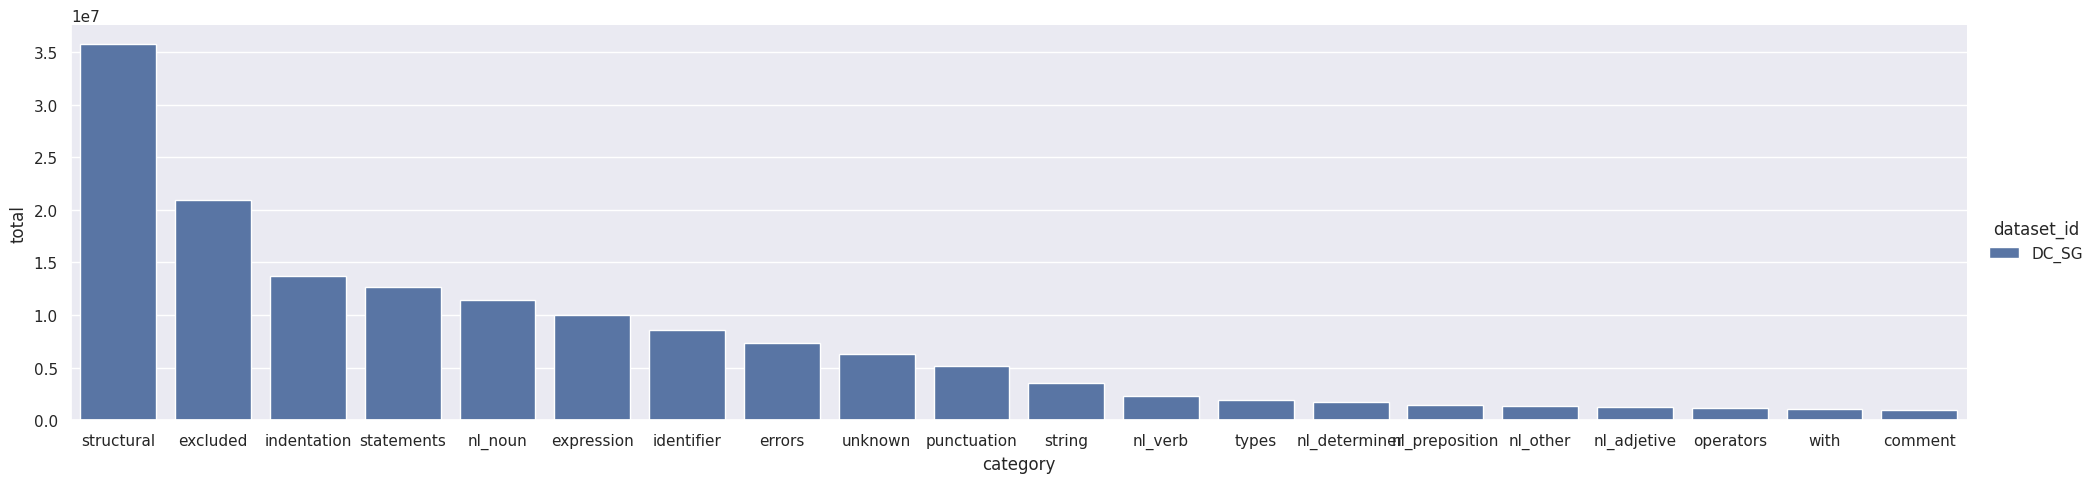

In [20]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_most_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 5: Most frequent concepts - DC

In [21]:
top_20_most_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'DC'].nlargest(20, 'total')
top_20_most_frequent_df = pd.concat([top_20_most_frequent_df, top_20_most_frequent_concepts_df], ignore_index=True)
top_20_most_frequent_concepts_df

,category,total,dataset_id
124,structural,10730502,DC
102,excluded,9668994,DC
125,statements,7351956,DC
110,nl_noun,6215701,DC
118,indentation,5868785,DC
119,expression,5060558,DC
134,unknown,4863710,DC
115,identifier,3626959,DC
120,punctuation,2526001,DC
114,errors,2484440,DC


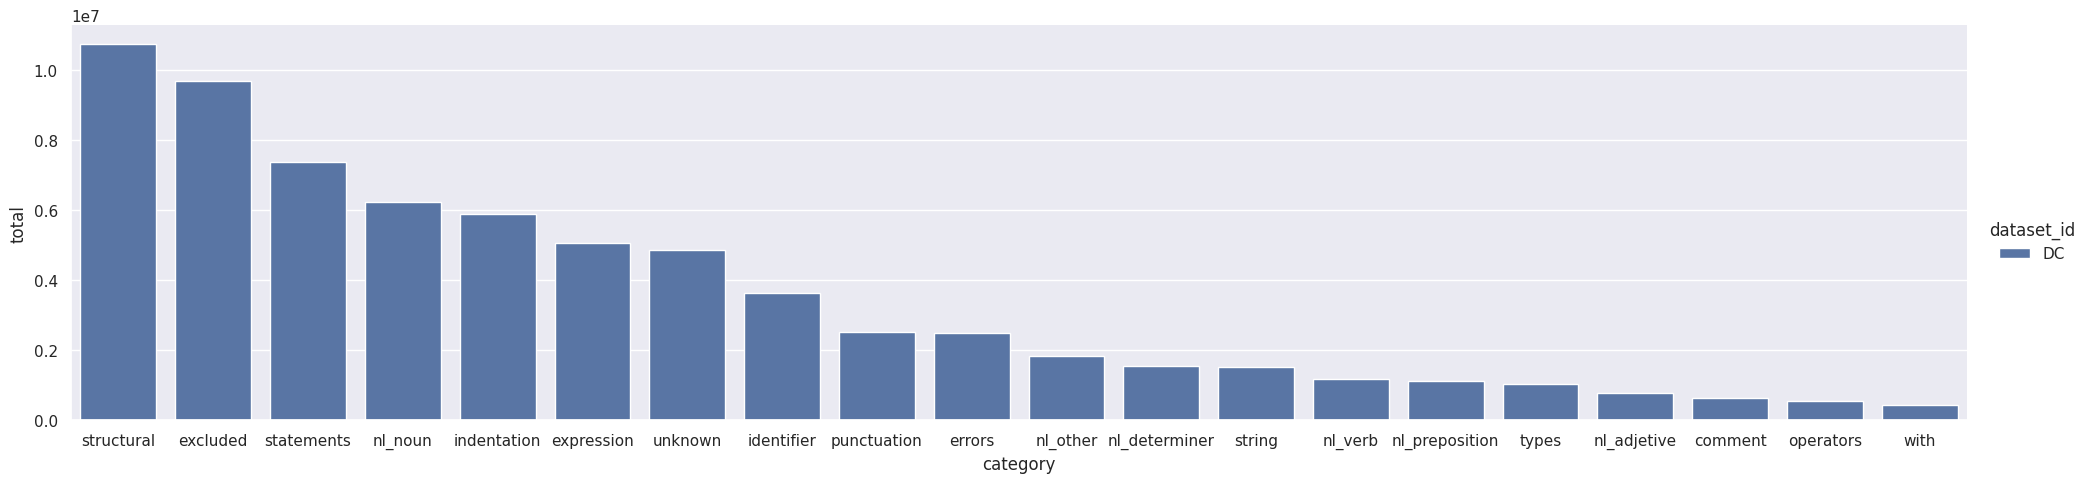

In [22]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_most_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 6: Venn Diagram for each dataset showing the intersection of most frequent concepts

In [23]:
mf_category_dict = {dataset_id : set(frequencies_df[frequencies_df['dataset_id'] == dataset_id].nlargest(20,'total')['category'].tolist()) for dataset_id in params['datasets'].keys()}

<AxesSubplot:>

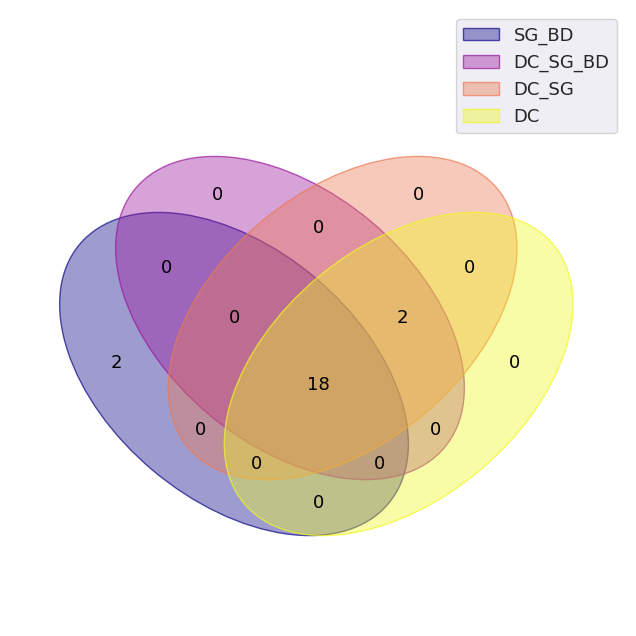

In [24]:
%matplotlib inline
venn(mf_category_dict,  cmap="plasma")

In [25]:
top_20_most_frequent_df = top_20_most_frequent_df.groupby(['category', 'dataset_id']).count().unstack(1)
top_20_most_frequent_df = top_20_most_frequent_df.sort_values(by=[('total', dataset_id) for dataset_id in params['datasets'].keys()], key=lambda x: x.isna())
top_20_most_frequent_df

total                     
dataset_id        DC DC_SG DC_SG_BD SG_BD
category                                 
comment         1.00  1.00     1.00  1.00
errors          1.00  1.00     1.00  1.00
excluded        1.00  1.00     1.00  1.00
expression      1.00  1.00     1.00  1.00
identifier      1.00  1.00     1.00  1.00
indentation     1.00  1.00     1.00  1.00
nl_adjetive     1.00  1.00     1.00  1.00
nl_noun         1.00  1.00     1.00  1.00
nl_other        1.00  1.00     1.00  1.00
nl_verb         1.00  1.00     1.00  1.00
operators       1.00  1.00     1.00  1.00
punctuation     1.00  1.00     1.00  1.00
statements      1.00  1.00     1.00  1.00
string          1.00  1.00     1.00  1.00
structural      1.00  1.00     1.00  1.00
types           1.00  1.00     1.00  1.00
unknown         1.00  1.00     1.00  1.00
with            1.00  1.00     1.00  1.00
nl_adverb        NaN   NaN      NaN  1.00
return           NaN   NaN      NaN  1.00
nl_determiner   1.00  1.00     1.00   NaN
nl_preposition  1.00  1.00     1.00   NaN

### Prototyping results
The following subsections show the generated *level_1* histograms and venn diagrams for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```modality``` at the beginning of the notebook and run the notebook until this point. 
- ```'modality'```

### Results - Modality SC

The following top rationales were shared among all datasets: 
[comments] [errors] [excluded] [expression] [identifier] [identation] [nl_adjetive] [nl_noun] [nl_other] [nl_verb] [operators] [punctuation] [statement] [string] [structural] [types] [unkown]

* Shared between [DC], [DC_SG], [SG_BD] : [nl_adverb]
* Shared between [DC], [DC_SG], [DC_SG_BD] : [nl_determiner] [nl_preposition]

##### Dataset [SG_BD]

* The top 10 types of level_1 rationales are the following: [errors] [excluded] [expression] [structural] [identifier] [nl_noun] [indetation] [punctuation] [statements] [unknown] [operators] [types] [string] [with] [nl_verb] [comment] [nl_other] [return] [nl_adjetive] [nl_adverb]
* unique types: [return] [with]

##### Dataset - [DC_SG_BD]
* The top 10 types of level_1 rationales are the following: [errors] [excluded] [identation] [expression] [identifier] [nl_noun] [structural] [punctuation] [statements] [unknown] [types] [operators] [string] [nl_preposition] [nl_verb] [nl_determiner] [comment] [nl_adjetive] [oop] [nl_other]
* unique types: [oop]

##### Dataset - [DC_SG]
* The top 10 types of level_1 rationales are the following: [errors] [excluded] [identation] [expression] [identifier] [nl_noun] [structural] [punctuation] [statements] [unknown] [types] [operators] [string] [nl_preposition] [nl_verb] [nl_determiner] [comment] [nl_adjetive] [nl_adverb] [nl_other]
* unique types: []

##### Dataset - [DC]
* The top 10 types of level_1 rationales are the following: [errors] [excluded] [identation] [expression] [identifier] [nl_noun] [structural] [punctuation] [statements] [unknown] [string] [types] [operators] [nl_preposition] [nl_determiner] [nl_verb] [comment] [nl_adjetive] [nl_other] [nl_adverb]
* unique types: []


#### Modality SC
![top_20_most_frequent_level_1.jpg](captures/frequencies/sc/top_20_most_frequent_level_1.jpg)

#### Modality NL_SC
![top_20_most_frequent_level_1.jpg](captures/frequencies/nl_sc/top_20_most_frequent_level_1.jpg)

## Experiment [1.1.2]
**Level 1 top 20 less frequent rationales**

*Research Question: What are the less frequent rationales for code completion?*

General Instructions: Execute this experiment per modality separately
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: Less frequent concepts - SG_BD

In [26]:
top_20_less_frequent_df = pd.DataFrame(columns=['category', 'total', 'dataset_id'])

In [27]:
top_20_less_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'SG_BD'].nsmallest(20, 'total')
top_20_less_frequent_df = pd.concat([top_20_less_frequent_df, top_20_less_frequent_concepts_df], ignore_index=True)
top_20_less_frequent_concepts_df

,category,total,dataset_id
7,nl_particle,135,SG_BD
6,nl_conjunction,1383,SG_BD
31,exceptions,1490,SG_BD
5,nl_modal,2024,SG_BD
11,nl_pronoun,2534,SG_BD
30,bool,3840,SG_BD
29,asserts,5441,SG_BD
4,nl_cardinal,6784,SG_BD
28,loops,9570,SG_BD
27,conditionals,11431,SG_BD


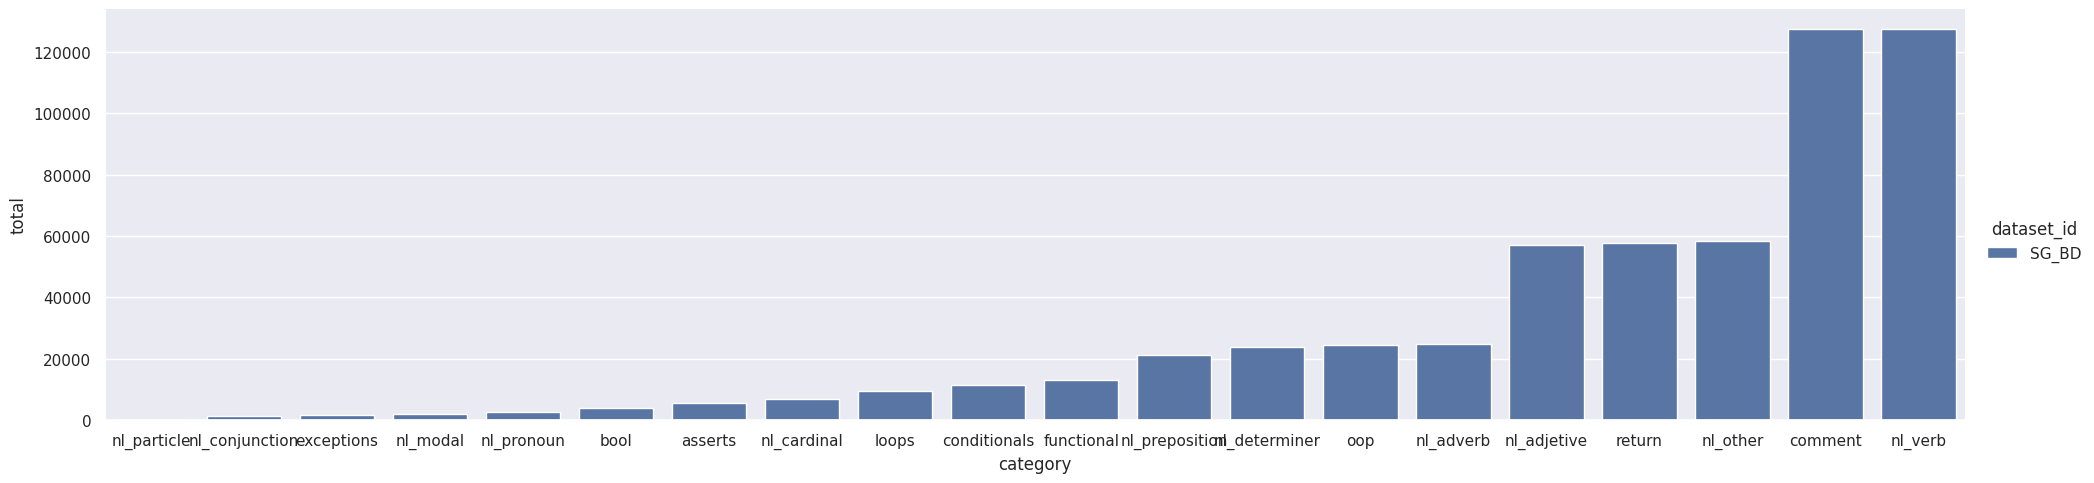

In [28]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_less_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 2: Less frequent concepts - DC_SG_BD

In [29]:
top_20_less_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'DC_SG_BD'].nsmallest(20, 'total')
top_20_less_frequent_df = pd.concat([top_20_less_frequent_df, top_20_less_frequent_concepts_df], ignore_index=True)
top_20_less_frequent_concepts_df

,category,total,dataset_id
41,nl_particle,6062,DC_SG_BD
65,asserts,34443,DC_SG_BD
64,bool,57461,DC_SG_BD
63,loops,60457,DC_SG_BD
55,functional,82834,DC_SG_BD
40,nl_modal,87062,DC_SG_BD
45,nl_pronoun,98267,DC_SG_BD
54,return,111200,DC_SG_BD
39,nl_cardinal,122116,DC_SG_BD
62,conditionals,159263,DC_SG_BD


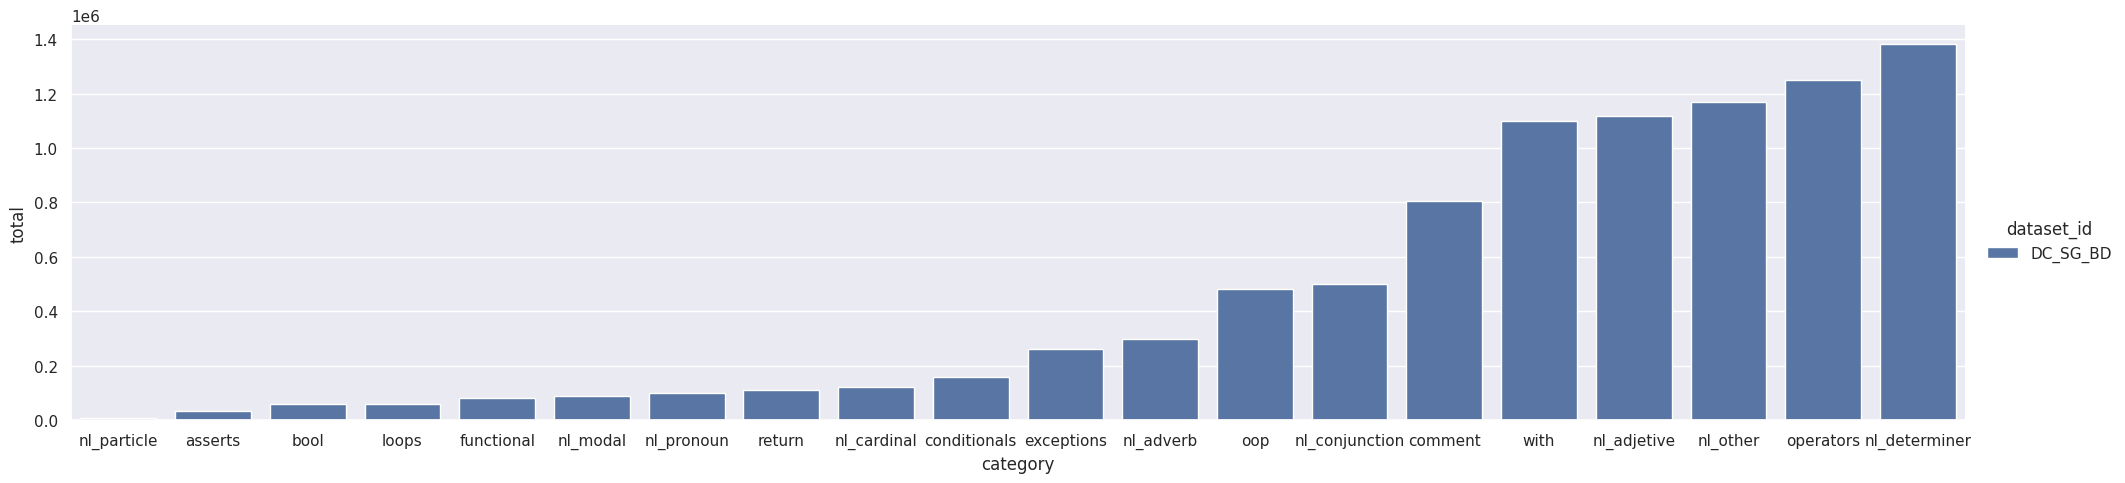

In [30]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_less_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 3: Less frequent concepts - DC_SG

In [31]:
top_20_less_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'DC_SG'].nsmallest(20, 'total')
top_20_less_frequent_df = pd.concat([top_20_less_frequent_df, top_20_less_frequent_concepts_df], ignore_index=True)
top_20_less_frequent_concepts_df

,category,total,dataset_id
75,nl_particle,9419,DC_SG
99,asserts,13129,DC_SG
98,loops,47887,DC_SG
89,functional,50156,DC_SG
97,bool,56170,DC_SG
88,return,89953,DC_SG
74,nl_modal,117670,DC_SG
96,conditionals,119321,DC_SG
73,nl_cardinal,133237,DC_SG
79,nl_pronoun,152520,DC_SG


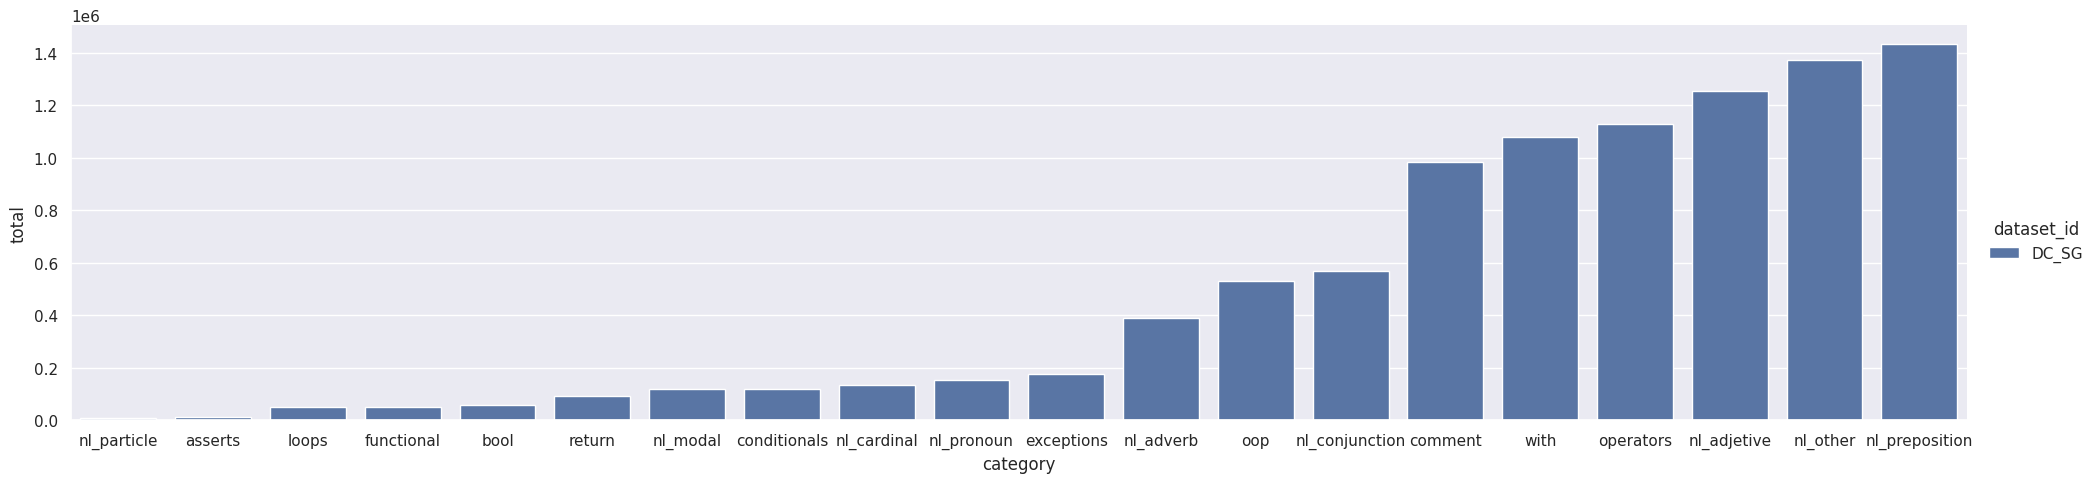

In [32]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_less_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 4: Less frequent concepts - DC

In [33]:
top_20_less_frequent_concepts_df = frequencies_df[frequencies_df['dataset_id'] == 'DC'].nsmallest(20, 'total')
top_20_less_frequent_df = pd.concat([top_20_less_frequent_df, top_20_less_frequent_concepts_df], ignore_index=True)
top_20_less_frequent_concepts_df

,category,total,dataset_id
133,asserts,5693,DC
109,nl_particle,9874,DC
123,functional,16342,DC
132,loops,25105,DC
131,bool,29927,DC
108,nl_modal,77616,DC
122,return,78467,DC
107,nl_cardinal,88495,DC
130,conditionals,101791,DC
113,nl_pronoun,112164,DC


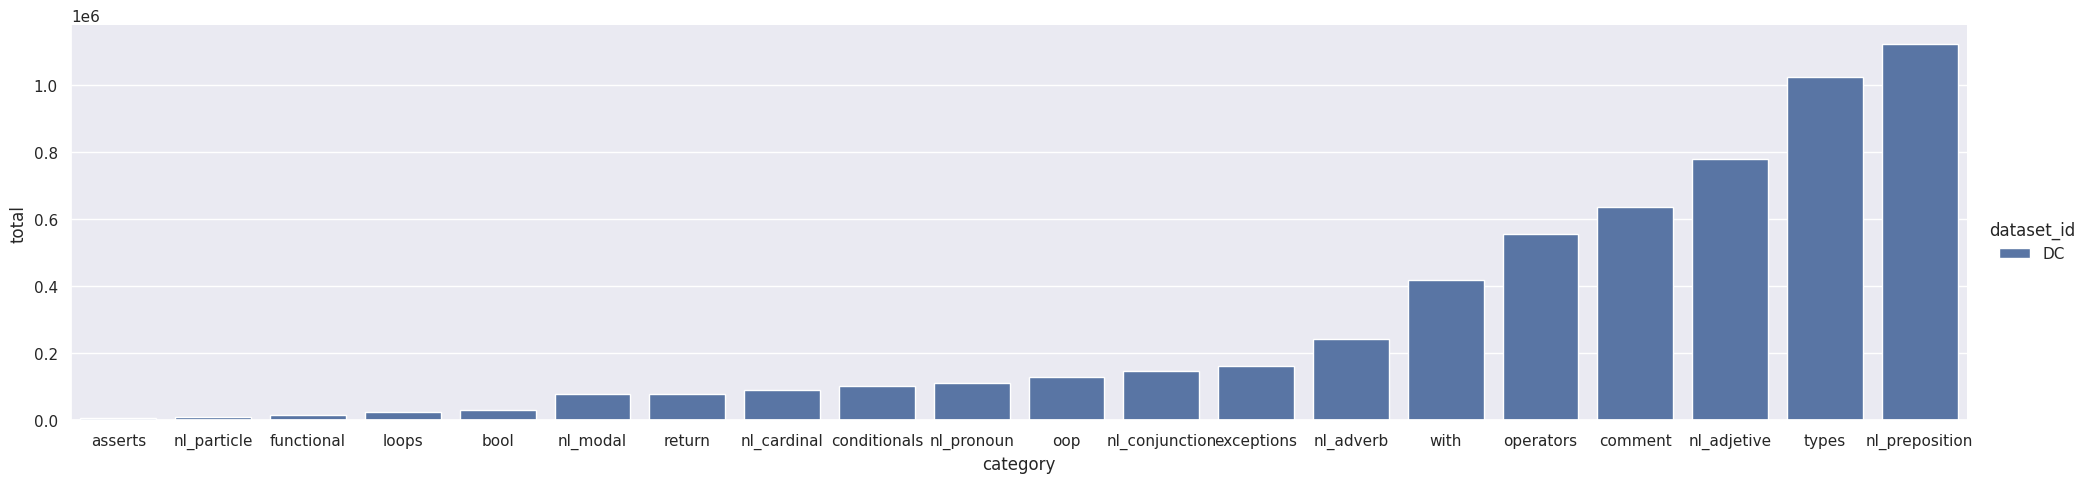

In [34]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=top_20_less_frequent_concepts_df, kind='bar', height=5, aspect=4)

#### Step 5: Venn Diagram for each dataset showing the intersection of less frequent concepts

In [35]:
lf_category_dict = {dataset_id : set(frequencies_df[frequencies_df['dataset_id'] == dataset_id].nsmallest(20,'total')['category'].tolist()) for dataset_id in params['datasets'].keys()}

<AxesSubplot:>

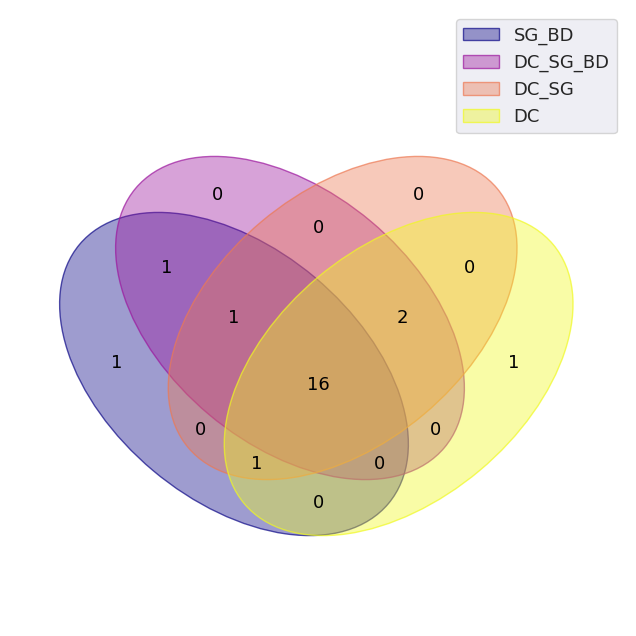

In [36]:
%matplotlib inline
venn(lf_category_dict,  cmap="plasma")

In [37]:
top_20_less_frequent_df = top_20_less_frequent_df.groupby(['category', 'dataset_id']).count().unstack(1)
top_20_less_frequent_df = top_20_less_frequent_df.sort_values(by=[('total', dataset_id) for dataset_id in params['datasets'].keys()], key=lambda x: x.isna())
top_20_less_frequent_df

total                     
dataset_id        DC DC_SG DC_SG_BD SG_BD
category                                 
asserts         1.00  1.00     1.00  1.00
bool            1.00  1.00     1.00  1.00
comment         1.00  1.00     1.00  1.00
conditionals    1.00  1.00     1.00  1.00
exceptions      1.00  1.00     1.00  1.00
functional      1.00  1.00     1.00  1.00
loops           1.00  1.00     1.00  1.00
nl_adjetive     1.00  1.00     1.00  1.00
nl_adverb       1.00  1.00     1.00  1.00
nl_cardinal     1.00  1.00     1.00  1.00
nl_conjunction  1.00  1.00     1.00  1.00
nl_modal        1.00  1.00     1.00  1.00
nl_particle     1.00  1.00     1.00  1.00
nl_pronoun      1.00  1.00     1.00  1.00
oop             1.00  1.00     1.00  1.00
return          1.00  1.00     1.00  1.00
nl_other         NaN  1.00     1.00  1.00
nl_determiner    NaN   NaN     1.00  1.00
nl_preposition  1.00  1.00      NaN  1.00
nl_verb          NaN   NaN      NaN  1.00
operators       1.00  1.00     1.00   NaN
with            1.00  1.00     1.00   NaN
types           1.00   NaN      NaN   NaN

### Prototyping results
The following subsections show the generated *level_1* histograms and venn diagrams for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```modality``` at the beginning of the notebook and run the notebook until this point. 
- ```'modality'```

### Results - Modality SC

The following top rationales were shared among all datasets: 
[asserts] [bools] [comment] [conditionals] [exceptions] [functional] [loops] [nl_adjective] [nl_adverb] [nl_cardinal] [nl_conjunction] [nl_determiner] [nl_modal] [nl_other] [nl_particle] [nl_pronoun] [nl_verb] [oop] [return]

* Shared between [DC], [DC_SG], [DC_SG_BD] : [with] 

##### Dataset [SG_BD]

* The top 10 types of level_1 rationales are the following: [asserts] [bools] [comment] [conditionals] [exceptions] [functional] [loops] [nl_adjective] [nl_adverb] [nl_cardinal] [nl_conjunction] [nl_determiner] [nl_modal] [nl_other] [nl_particle] [nl_pronoun] [nl_verb] [oop] [return] [nl_preposition]
* unique types: [nl_preposition]

##### Dataset - [DC_SG_BD]
* The top 10 types of level_1 rationales are the following: [asserts] [bools] [comment] [conditionals] [exceptions] [functional] [loops] [nl_adjective] [nl_adverb] [nl_cardinal] [nl_conjunction] [nl_determiner] [nl_modal] [nl_other] [nl_particle] [nl_pronoun] [nl_verb] [oop] [return] [with]
* unique types: []

##### Dataset - [DC_SG]
* The top 10 types of level_1 rationales are the following: [asserts] [bools] [comment] [conditionals] [exceptions] [functional] [loops] [nl_adjective] [nl_adverb] [nl_cardinal] [nl_conjunction] [nl_determiner] [nl_modal] [nl_other] [nl_particle] [nl_pronoun] [nl_verb] [oop] [return] [with]
* unique types: []

##### Dataset - [DC]
* The top 10 types of level_1 rationales are the following: [asserts] [bools] [comment] [conditionals] [exceptions] [functional] [loops] [nl_adjective] [nl_adverb] [nl_cardinal] [nl_conjunction] [nl_determiner] [nl_modal] [nl_other] [nl_particle] [nl_pronoun] [nl_verb] [oop] [return] [with]
* unique types: []




#### Modality SC
![top_20_less_frequent_level_1.jpg](captures/frequencies/sc/top_20_less_frequent_level_1.jpg)

#### Modality NL_SC
![top_20_less_frequent_level_1.jpg](captures/frequencies/nl_sc/top_20_less_frequent_level_1.jpg)